## Setups, Installations and Imports

In [2]:
# Basic Installations requirements
!pip install tensorflow==2.0
!pip install tensorflow-gpu==2.0
!pip install opencv-python

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0 (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu==2.0
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from os import listdir
from os.path import isfile, join

## Creating training data

- Download the images from link http://data.csail.mit.edu/places/places365/val_large.tar
- Segregate the images into three folders - Train, Test and Validate
- Follow the Change tags below

In [11]:
# Training data 
path = "/Users/indrakaran_varikuti/Downloads/Train"
train = np.empty((30,128,128,3)) # Change the count to number of images (10000,128,128,3)
i = 0
count = 0
for file in listdir(path):
    if file == ".DS_Store":
        count += 1
        continue 
    data = np.array(Image.open(join(path,file)).resize((128,128)))
    if len(data.shape) != 3:
        count += 1
        continue
    train[i] = data
    i += 1
    if i == 30: # Change the count to number of images as mentioned above
        break

In [12]:
# Validation Images
path = "/Users/indrakaran_varikuti/Downloads/Validate"
validate = np.empty((30,128,128,3)) # Change the count to number of images (5000,128,128,3)
i = 0
count = 0
for file in listdir(path):
    if file == ".DS_Store":
        count += 1
        continue 
    data = np.array(Image.open(join(path,file)).resize((128,128)))
    if len(data.shape) != 3:
        count += 1
        continue
    validate[i] = data
    i += 1
    if i == 30: # Change the count to number of images as mentioned above
        break

In [13]:
# Test Images
path = "/Users/indrakaran_varikuti/Downloads/Test"
test = np.empty((30,128,128,3)) # Change the count to number of images (5000,128,128,3)
i = 0
count = 0
for file in listdir(path):
    if file == ".DS_Store":
        count += 1
        continue 
    data = np.array(Image.open(join(path,file)).resize((128,128)))
    if len(data.shape) != 3:
        count += 1
        continue
    test[i] = data
    i += 1
    if i == 30:
        break

## Preprocessing and Preparation

- Below section creates masks using using lines of random lenght creates using numpy array 
- Masked Images are created combining the masks and original image using Computer Vision

In [14]:
# Create masks random and combine with the images
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, dim = (128,128), batch_size = 5, n_channels=3, shuffle=True): 
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      X_inputs, y_output = self.__data_generation(indexes)
      return X_inputs, y_output

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # Masked_images is a matrix of masked images used as input
    Masked_images = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # Mask_batch is a matrix of binary masks used as input
    Mask_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Binary Masks
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image
    

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image, mask = self.__createMask(image_copy)
      
      Masked_images[i,] = masked_image/255
      Mask_batch[i,] = mask/255
      y_batch[i] = self.y[idx]/255

    ## Return mask as well because partial convolution require the same.
    return [Masked_images, Mask_batch], y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((self.dim[0],self.dim[1],3), 255, np.uint8) ## White background
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, self.dim[0]), np.random.randint(1, self.dim[0])
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, self.dim[1]), np.random.randint(1, self.dim[1])
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3) #Change it to 1,9
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(0,0,0),thickness)

    ## Mask the image
    masked_image = img.copy()
    masked_image[mask==0] = 255

    return masked_image, mask

In [15]:
# Produce Training, Validation and Test Masked Images along with Mask
traingen = createAugment(train,train)
validgen = createAugment(validate,validate)
testgen = createAugment(test,test)

## Partial Convolution Based Autoencoder-Decoder Model 

In [16]:
## utils is present in the repository. Visit repo for the implementation of PConv2D.
from pconv_layer import PConv2D

In [17]:
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [18]:
class InpaintingModel_punet:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(128,128,3)): #Change 5
    input_image = keras.layers.Input(input_size)
    input_mask = keras.layers.Input(input_size, name='encoder_input')
  
    conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask, ['conv1', 'conv2'])
    conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'])
    conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'])
    conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'])

    conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'])
    conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'])
    conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'])
    conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'])

    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    return keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])
    
  def __encoder_layer(self, filters, in_layer, in_mask, names):
    conv1, mask1 = PConv2D(filters, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filters, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2, training=True)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

  def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names):
    up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
    up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
    concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
    concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

    conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

## Convolution Based Autoencoder-Decoder Model(U-Net based)

In [19]:
class inpaintingModel_unet:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(128,128,3)):
    inputs = keras.layers.Input(input_size)

    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)
    
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

## Initializing and Training the Model

### Convolution based Model

In [20]:
keras.backend.clear_session()
# U-Net Model based on CNN
model_unet = inpaintingModel_unet().prepare_model()
model_unet.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [22]:
_ = model_unet.fit_generator(traingen, validation_data=validgen, 
          epochs=3,
          steps_per_epoch=len(traingen), 
          validation_steps=len(validgen),
          use_multiprocessing=True)

Epoch 1/3
6/6 [==============================] - 16s 3s/step - loss: 0.2352 - dice_coef: 0.4719 - val_loss: 0.2490 - val_dice_coef: 0.4609
Epoch 2/3
6/6 [==============================] - 16s 3s/step - loss: 0.2118 - dice_coef: 0.4983 - val_loss: 0.1953 - val_dice_coef: 0.5053
Epoch 3/3
6/6 [==============================] - 16s 3s/step - loss: 0.1778 - dice_coef: 0.5103 - val_loss: 0.1673 - val_dice_coef: 0.5215


### Partial Convolution based Model

In [24]:
keras.backend.clear_session()
# U-Net Model based on CNN
model_punet = InpaintingModel_punet().prepare_model()
model_punet.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
model_punet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1 (PConv2D)                 [(None, 128, 128, 32 1760        input_1[0][0]                    
                                                                 encoder_input[0][0]              
__________________________________________________________________________________________________
tf_op_layer_Relu (TensorFlowOpL [(None, 128, 128, 32 0           conv1[0][0]                  

In [25]:
_ = model_punet.fit_generator(traingen, validation_data=validgen, 
          epochs=3,
          steps_per_epoch=len(traingen), 
          validation_steps=len(validgen),
          use_multiprocessing=True)

Epoch 1/3
6/6 [==============================] - 35s 6s/step - loss: 0.2381 - dice_coef: 0.4635 - val_loss: 0.2583 - val_dice_coef: 0.4418
Epoch 2/3
6/6 [==============================] - 29s 5s/step - loss: 0.2379 - dice_coef: 0.4650 - val_loss: 0.2579 - val_dice_coef: 0.4431
Epoch 3/3
6/6 [==============================] - 29s 5s/step - loss: 0.2376 - dice_coef: 0.4644 - val_loss: 0.2575 - val_dice_coef: 0.4427


## Save Model to use it later

In [34]:
model_unet.save('/Users/indrakaran_varikuti/Downloads/ptrained_model_64_10.h5')

In [6]:
from tensorflow import keras
model = keras.models.load_model('/Users/indrakaran_varikuti/Desktop/Final Trained Models /trained_model_1.h5',custom_objects={'dice_coef': dice_coef,'PConv2D': PConv2D})

## Testing on images

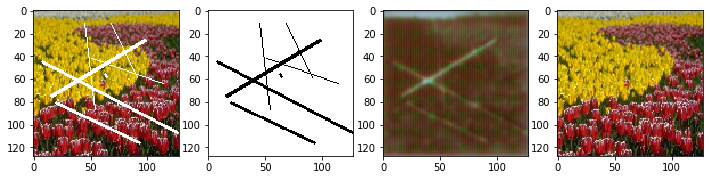

In [26]:
## Legend: Original Image | Mask generated | Inpainted Image | Ground Truth

## Examples
rows = 1
sample_idx = 1
[masked_images, masks], sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(ncols=4,figsize=(12, 7))

for i in range(1): 
  inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
  impainted_image = model_unet.predict(inputs)
  axs[0].imshow(masked_images[i])
  axs[1].imshow(masks[i])
  axs[2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  axs[3].imshow(sample_labels[i])
  
plt.show()

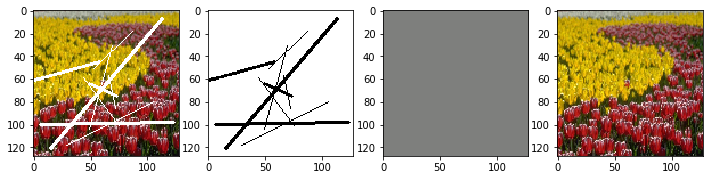

In [27]:
## Legend: Original Image | Mask generated | Inpainted Image | Ground Truth

## Examples
rows = 1
sample_idx = 1
[masked_images, masks], sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(ncols=4,figsize=(12, 7))

for i in range(1): 
  inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
  impainted_image = model_punet.predict(inputs)
  axs[0].imshow(masked_images[i])
  axs[1].imshow(masks[i])
  axs[2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  axs[3].imshow(sample_labels[i])
  
plt.show()

# Final Test Ground

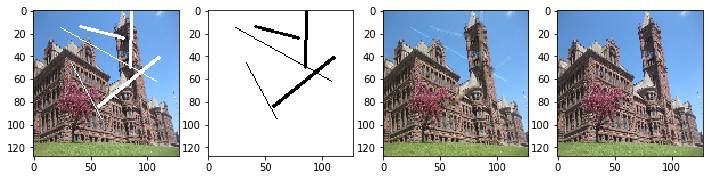

In [3]:
# Change the image path and model path - Convolution
from Final_Test import testing
%matplotlib inline
testing("/Users/indrakaran_varikuti/Downloads/Train/Places365_val_00006060.jpg", "/Users/indrakaran_varikuti/Desktop/Image Inpainting/Final Trained Models /Conv_trained_128_10.h5")

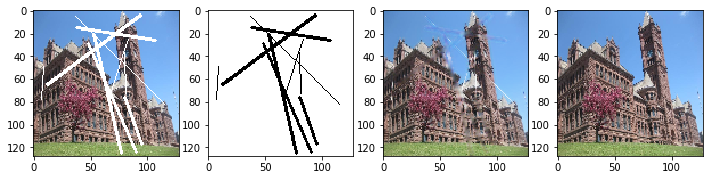

In [4]:
# Change the image path and model path - Partial Convolution
from Final_Test import testing
%matplotlib inline
testing("/Users/indrakaran_varikuti/Downloads/Train/Places365_val_00006060.jpg", "/Users/indrakaran_varikuti/Desktop/Image Inpainting/Final Trained Models /Ptrained_128_10.h5")